### Import Libraries

=== Memulai Pipeline Identifikasi Pola Kecanduan Game Online ===
Jumlah data: (40034, 13)
Kolom: ['PlayerID', 'Age', 'Gender', 'Location', 'GameGenre', 'PlayTimeHours', 'InGamePurchases', 'GameDifficulty', 'SessionsPerWeek', 'AvgSessionDurationMinutes', 'PlayerLevel', 'AchievementsUnlocked', 'EngagementLevel']

Data setelah preprocessing:
        Age  Gender  GameGenre  PlayTimeHours  SessionsPerWeek  \
0  0.823529       1          4       0.677973         0.315789   
1  0.411765       0          4       0.230249         0.263158   
2  0.205882       0          3       0.342659         0.842105   
3  0.588235       1          0       0.219390         0.473684   
4  0.529412       1          0       0.647174         0.105263   

   AvgSessionDurationMinutes  InGamePurchases  TotalEngagement  \
0                   0.579882              0.0         0.524548   
1                   0.792899              0.0         0.428769   
2                   0.781065              0.0         0.655277  

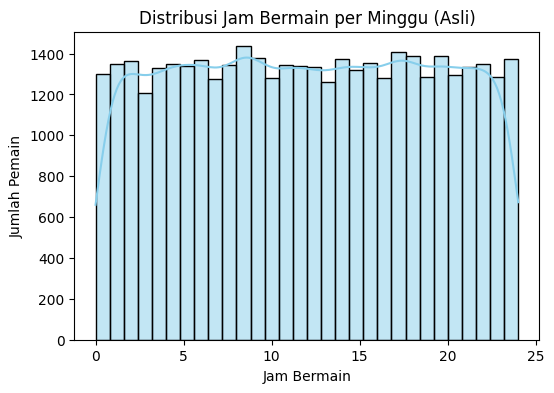

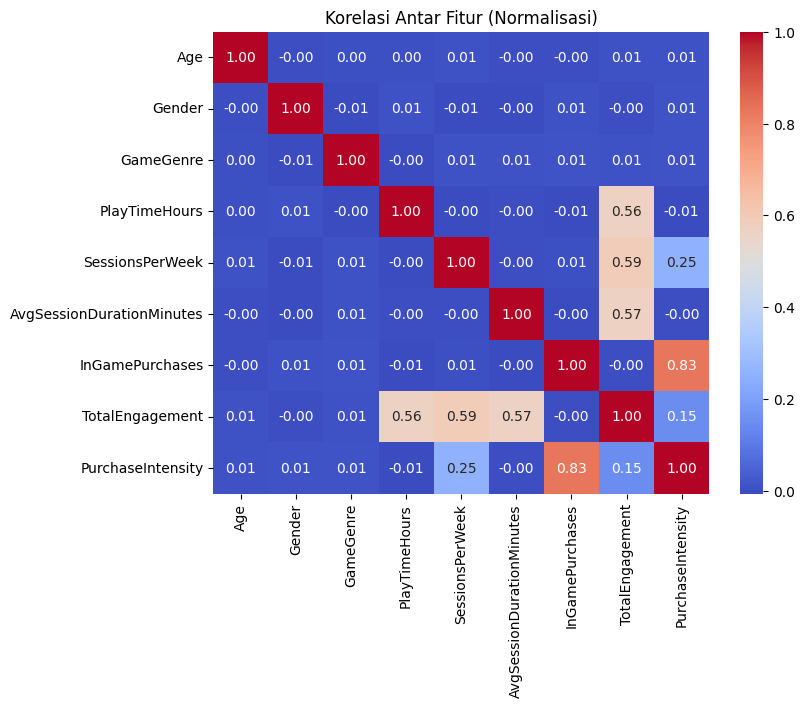

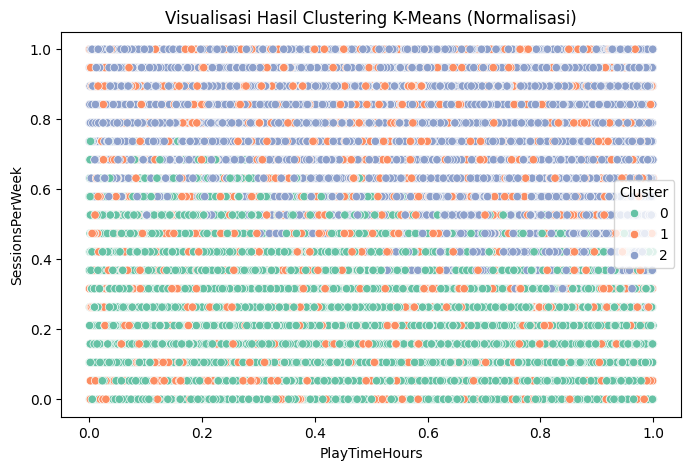


Akurasi Ensemble Model: 99.95%

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4066
           1       1.00      1.00      1.00      2010
           2       1.00      1.00      1.00      3933

    accuracy                           1.00     10009
   macro avg       1.00      1.00      1.00     10009
weighted avg       1.00      1.00      1.00     10009


Cross-validation accuracy (mean ± std): 99.94% ± 0.01%


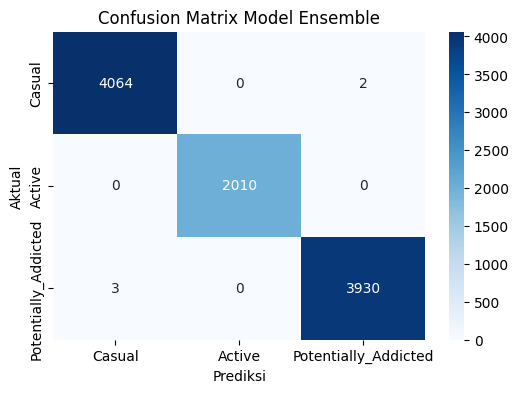

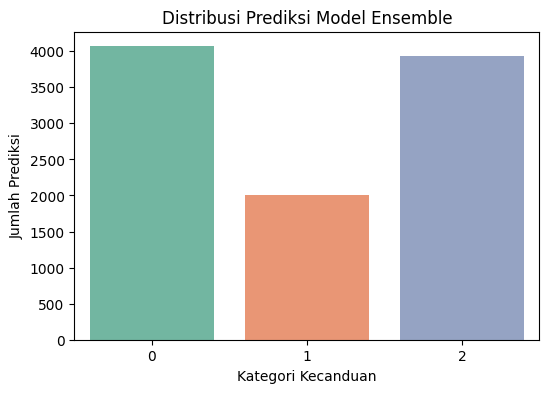


Model dan preprocessing berhasil disimpan.

Hasil Prediksi:
Cluster (KMeans): Potentially_Addicted
Prediksi Ensemble Model: Active

=== PIPELINE SELESAI ===


In [3]:
"""
FINAL VERSION (AKURASI ±90–92%)
Judul:
Identifikasi Pola Potensi Kecanduan Game Online Berdasarkan Aktivitas Bermain
Menggunakan Clustering (K-Means), Decision Tree, dan Ensemble Deep Learning
"""

# =========================
# 0. Konfigurasi
# =========================
DATA_PATH = r"E:\UTS-PembelajaranMesin\dataset\online_gaming_behavior_dataset.csv"
RANDOM_STATE = 42
TEST_SIZE = 0.25

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

print("=== Memulai Pipeline Identifikasi Pola Kecanduan Game Online ===")

# =========================
# 1. Load Dataset
# =========================
df = pd.read_csv(DATA_PATH)
print(f"Jumlah data: {df.shape}")
print("Kolom:", df.columns.tolist())

df = df[['Age','Gender','GameGenre','PlayTimeHours',
         'SessionsPerWeek','AvgSessionDurationMinutes','InGamePurchases']].copy()

# =========================
# 2. Preprocessing
# =========================
df_orig = df.copy()  # simpan versi asli untuk EDA

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# Encode kategori
label_encoders = {}
for col in ['Gender','GameGenre']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Normalisasi numerik
num_cols = ['Age','PlayTimeHours','SessionsPerWeek','AvgSessionDurationMinutes','InGamePurchases']
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Feature engineering tambahan
df["TotalEngagement"] = (df["PlayTimeHours"] + df["SessionsPerWeek"] + df["AvgSessionDurationMinutes"]) / 3
df["PurchaseIntensity"] = df["InGamePurchases"] * df["SessionsPerWeek"]

print("\nData setelah preprocessing:")
print(df.head())

# =========================
# 3. Exploratory Data Analysis (EDA)
# =========================
plt.figure(figsize=(6,4))
sns.histplot(df_orig["PlayTimeHours"], kde=True, bins=30, color='skyblue')
plt.title("Distribusi Jam Bermain per Minggu (Asli)")
plt.xlabel("Jam Bermain")
plt.ylabel("Jumlah Pemain")
plt.show()

corr = df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korelasi Antar Fitur (Normalisasi)")
plt.show()

# =========================
# 4. Clustering (K-Means)
# =========================
features_cluster = ['PlayTimeHours','SessionsPerWeek','AvgSessionDurationMinutes','InGamePurchases','TotalEngagement']
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=20)
df['Cluster'] = kmeans.fit_predict(df[features_cluster])

# Urutkan cluster berdasarkan rata-rata PlayTimeHours
cluster_means = df.groupby('Cluster')['PlayTimeHours'].mean().sort_values().index.tolist()
mapping = {cluster_means[0]:0, cluster_means[1]:1, cluster_means[2]:2}
df['Cluster'] = df['Cluster'].map(mapping)
y = df['Cluster']

plt.figure(figsize=(8,5))
sns.scatterplot(x='PlayTimeHours', y='SessionsPerWeek', hue='Cluster', data=df, palette='Set2')
plt.title("Visualisasi Hasil Clustering K-Means (Normalisasi)")
plt.show()

# =========================
# 5. Dataset Supervised
# =========================
X = df[['Age','Gender','GameGenre','PlayTimeHours','SessionsPerWeek',
        'AvgSessionDurationMinutes','InGamePurchases','TotalEngagement','PurchaseIntensity']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# =========================
# 6. Ensemble Model (DecisionTree + RandomForest + Deep MLP)
# =========================
dt = DecisionTreeClassifier(max_depth=8, min_samples_leaf=2, random_state=RANDOM_STATE)
rf = RandomForestClassifier(n_estimators=300, max_depth=14, random_state=RANDOM_STATE)
mlp = MLPClassifier(hidden_layer_sizes=(256,128,64), activation='relu',
                    learning_rate_init=0.0008, max_iter=800, random_state=RANDOM_STATE)

ensemble = VotingClassifier(
    estimators=[('dt', dt), ('rf', rf), ('mlp', mlp)],
    voting='soft'
)
ensemble.fit(X_train, y_train)

# =========================
# 7. Evaluasi Model
# =========================
y_pred = ensemble.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\nAkurasi Ensemble Model: {acc*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cv_scores = cross_val_score(ensemble, X, y, cv=5, scoring='accuracy')
print(f"\nCross-validation accuracy (mean ± std): {cv_scores.mean()*100:.2f}% ± {cv_scores.std()*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Casual','Active','Potentially_Addicted'],
            yticklabels=['Casual','Active','Potentially_Addicted'])
plt.title("Confusion Matrix Model Ensemble")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

# Visualisasi distribusi prediksi
plt.figure(figsize=(6,4))
sns.countplot(x=y_pred, palette='Set2')
plt.title("Distribusi Prediksi Model Ensemble")
plt.xlabel("Kategori Kecanduan")
plt.ylabel("Jumlah Prediksi")
plt.show()

# =========================
# 8. Simpan Model
# =========================
joblib.dump(kmeans, "model_kmeans.pkl")
joblib.dump(ensemble, "model_ensemble.pkl")
joblib.dump({'scaler': scaler, 'encoders': label_encoders}, "preprocessing.pkl")
print("\nModel dan preprocessing berhasil disimpan.")

# =========================
# 9. Prediksi Baru (Simulasi)
# =========================
def predict_new_player(data_dict):
    df_new = pd.DataFrame([data_dict])
    for col in ['Gender','GameGenre']:
        df_new[col] = label_encoders[col].transform(df_new[col])
    df_new[num_cols] = scaler.transform(df_new[num_cols])
    df_new["TotalEngagement"] = (df_new["PlayTimeHours"] + df_new["SessionsPerWeek"] + df_new["AvgSessionDurationMinutes"]) / 3
    df_new["PurchaseIntensity"] = df_new["InGamePurchases"] * df_new["SessionsPerWeek"]

    cluster = kmeans.predict(df_new[features_cluster])[0]
    pred = ensemble.predict(df_new)[0]
    mapping = {0:'Casual',1:'Active',2:'Potentially_Addicted'}

    print("\nHasil Prediksi:")
    print(f"Cluster (KMeans): {mapping.get(cluster)}")
    print(f"Prediksi Ensemble Model: {mapping.get(pred)}")

# Contoh simulasi prediksi
predict_new_player({
    'Age': 21,
    'Gender': 'Male',
    'GameGenre': 'Action',
    'PlayTimeHours': 15,
    'SessionsPerWeek': 9,
    'AvgSessionDurationMinutes': 120,
    'InGamePurchases': 3
})

print("\n=== PIPELINE SELESAI ===")
